# Differentiable Fluid Simulations

Next, we'll target a more complex example with the Navier-Stokes equations as physical model. In line with {doc}`overview-ns-forw`, we'll target a 2D case.

As optimization objective we'll consider a more difficult variant of the previous Burgers example: the state of the observed density $s$ should match a given target after $n=20$ steps of simulation. In contrast to before, the observed quantity in the form of the marker field $s$ cannot be changed in any way. Only the initial state of the velocity $\mathbf{u}_0$ at $t=0$ can be modified. This gives us a split between observable quantities for the loss formulation and quantities that we can interact with during the optimization (or later on via NNs).
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/diffphys-code-ns.ipynb)

## Physical Model

We'll use a Navier-Stokes model with velocity $\mathbf{u}$, no explicit viscosity term, and a smoke marker density $s$ that drives a simple Boussinesq buoyancy term $\eta d$ adding a force along the y dimension. For the velocity this gives:

$\begin{aligned}
  \frac{\partial u_x}{\partial{t}} + \mathbf{u} \cdot \nabla u_x &= - \frac{1}{\rho} \nabla p 
  \\
  \frac{\partial u_y}{\partial{t}} + \mathbf{u} \cdot \nabla u_y &= - \frac{1}{\rho} \nabla p + \eta d
  \\
  \text{s.t.} \quad \nabla \cdot \mathbf{u} &= 0,
\end{aligned}$

With an additional transport equation for the passively advected marker density $s$:

$\begin{aligned}
  \frac{\partial s}{\partial{t}} + \mathbf{u} \cdot \nabla s &= 0 
\end{aligned}$



## Formulation


With the notation from {doc}`overview-equations` the inverse problem outlined above can be formulated as a  minimization problem 

$$
\text{arg min}_{\mathbf{u}_{0}} \sum_i |f(x_{t_e,i} ; \mathbf{u}_{0} )-y^*_{t_e,i}|^2 ,
$$

where $y^*_{t_e,i}$ are samples of the reference solution at a targeted time $t_e$,
and $x_{t_e,i}$ denotes the estimate of our simulator at the same
sampling locations and time. 
The index $i$ here runs over all discretized, spatial degrees of freedom in our fluid solver (we'll have $32\times40$ below).

In contrast to before, we are not dealing with pre-computed quantities anymore, but now $x_{t_e,i}$ is a complex, non-linear function itself.
More specifically, the simulator starts with the initial velocity $\mathbf{u}_0$ and density $s_0$ to compute the $x_{t_e,i}$, by $n$ evaluations of the discretized PDE $\mathcal{P}$.
This gives as simulated final state 
$y_{t_e,i} = s_{t_e} = \mathcal{P}^n(\mathbf{u}_0,s_0)$, where we will leave $s_0$ fixed in the following, and focus on $\mathbf{u}_0$ as our degrees of freedom.
Hence, the optimization can only change $\mathbf{u}_0$ to align $y_{t_e,i}$ with the references $y^*_{t_e,i}$ as closely as possible.




## Starting the Implementation

First, let's get the loading of python modules out of the way. By importing `phi.torch.flow`, we get fluid simulation functions that work within pytorch graphs and can provide gradients (`phi.tf.flow` would be the alternative for tensorflow).



In [1]:
#!pip install --upgrade --quiet phiflow
!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop

from phi.torch.flow import *  
import pylab # for visualizations later on


## Batched simulations

Now we can set up the simulation, which will work in line with the previous "regular" simulation example from the {doc}`overview-ns-forw`. However, now we'll directly include an additional dimension, similar to a mini-batch used for NN training. For this, we'll introduce a named dimension called `inflow_loc`. This dimension will exist "above" the previous spatial dimensions `y`, `x` and the channel dimensions `vector`. As indicated by the name `inflow_loc`, the main differences for this dimension will lie in different locations of the inflow, in order to obtain different flow simulations. The named dimensions in phiflow make it very convenient to broadcast information across matching dimensions in different tensors.

The `Domain` object is allocated just like before, but the `INFLOW_LOCATION` tensor now receives a string
`'inflow_loc,vector'` that indicates the names of the two dimensions. This leads to the creation of an `inflow_loc` dimensions in addition to the two spatial dimensions (the `vector` part).


In [2]:
# closed domain
INFLOW_LOCATION = tensor([(12, 4), (13, 6), (14, 5), (16, 5)], batch('inflow_loc'), channel('vector'))
INFLOW = (1./3.) * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.BOUNDARY, x=32, y=40, bounds=Box[0:32, 0:40])
BND = extrapolation.ZERO # closed, boundary conditions for velocity grid below

# uncomment this for a slightly different open domain case
#INFLOW_LOCATION = tensor([(11, 6), (12, 4), (14, 5), (16, 5)], batch('inflow_loc'), channel('vector'))
#INFLOW = (1./4.) * CenteredGrid(Sphere(center=INFLOW_LOCATION, radius=3), extrapolation.BOUNDARY, x=32, y=40, bounds=Box[0:32, 0:40])
#BND = extrapolation.BOUNDARY # open boundaries 

INFLOW.shape

(inflow_locᵇ=4, xˢ=32, yˢ=40)

The last statement verifies that our `INFLOW` grid likewise has an `inflow_loc` dimension in addition to the spatial dimensions `x` and `y`. You can test for the existence of a tensor dimension in phiflow with the `.exists` boolean, which can be evaluated for any dimension name. E.g., above `INFLOW.inflow_loc.exists` will give `True`, while `INFLOW.some_unknown_dim.exists` will give `False`. The $^b$ superscript indicates that `inflow_loc` is a batch dimension.

Phiflow tensors are automatically broadcast to new dimensions via their names, and hence typically no-reshaping operations are required. E.g., you can easily add or multiply tensors with differing dimensions. Below we'll multiply a staggered grid with a tensor of ones along the `inflow_loc` dimension to get a staggered velocity that has `x,y,inflow_loc` as dimensions via `StaggeredGrid(...) * math.ones(batch(inflow_loc=4))`.

We can easily simulate a few steps now starting with these different initial conditions. Thanks to the broadcasting, the exact same code we used for the single forward simulation in the overview chapter will produce four simulations with different smoke inflow positions.

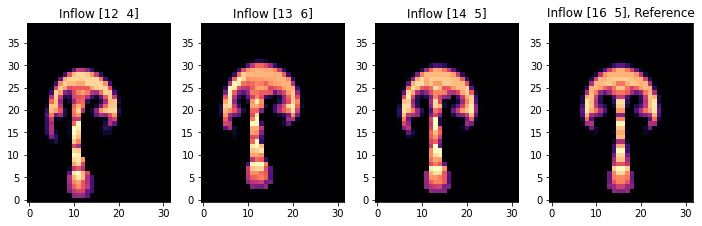

In [3]:
smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box[0:32, 0:40])  # sampled at cell centers
velocity = StaggeredGrid(0, BND, x=32, y=40, bounds=Box[0:32, 0:40])  # sampled in staggered form at face centers 

def step(smoke, velocity):
  smoke = advect.mac_cormack(smoke, velocity, dt=1) + INFLOW
  buoyancy_force = smoke * (0, 1) >> velocity
  velocity = advect.semi_lagrangian(velocity, velocity, dt=1) + buoyancy_force
  velocity, _ = fluid.make_incompressible(velocity)
  return smoke, velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

# store and show final states (before optimization)
smoke_final = smoke 
fig, axes = pylab.subplots(1, 4, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')):
  axes[i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...], origin='lower', cmap='magma')
  axes[i].set_title(f"Inflow {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}" + (", Reference" if i==3 else ""))
pylab.tight_layout()


The last image shows the state of the advected smoke fields after 20 simulation steps. The final smoke shape of simulation `[3]` with an inflow at `(16,5)`, with the straight plume on the far right, will be our **reference state** below. The initial velocity of the other three will be modified in the optimization procedure below to match this reference.

(As a small side note: phiflow tensors will keep track of their chain of operations using the backend they were created for. E.g. a tensor created with NumPy will keep using NumPy/SciPy operations unless a PyTorch or TensorFlow tensor is also passed to the same operation. Thus, it is a good idea to verify that tensors are using the right backend once in a while, e.g., via `GRID.values.default_backend`.)


## Gradients

Let's look at how to get gradients from our simulation. The first trivial step taken care of above was to include `phi.torch.flow` to import differentiable operators from which to build our simulator.

Now we want to optimize the initial velocities so that all simulations arrive at a final state that is similar to the simulation on the right, where the inflow is located at `(16, 5)`, i.e. centered along `x`.
To achieve this, we record the gradients during the simulation and define a simple $L^2$ based loss function. The loss function we'll use is given by $L = | s_{t_e} - s_{t_e}^* |^2$, where $s_{t_e}$ denotes the smoke density, and $s_{t_e}^*$
denotes the reference state from the fourth simulation in our batch (both evaluated at the last time step $t_e$).
When evaluating the loss function we treat the reference state as an external constant via `field.stop_gradient()`.
As outlined at the top, $s$ is a function of $\mathbf{u}$ (via the advection equation), which in turn is given by the Navier-Stokes equations. Thus, via a chain of multiple time steps $s$ depends in the initial velocity state $\mathbf{u}_0$.

It is important that our initial velocity has the `inflow_loc` dimension before we record the gradients, such that we have the full "mini-batch" of four versions of our velocity (three of which will be updated via gradients in our optimization later on). To get the appropriate velocity tensor, we initialize a `StaggeredGrid` with a tensor of zeros along the `inflow_loc` batch dimension. As the staggered grid already has `y,x` and `vector` dimensions, this gives the desired four dimensions, as verified by the print statement below.

Phiflow provides a unified API for gradients across different platforms by using functions that need to return a loss values, in addition to optional state values. It uses a loss function based interface, for which we define the `simulate` function below. `simulate` computes the $L^2$ error outlined above and returns the evolved `smoke` and `velocity` states after 20 simulation steps.


In [4]:
initial_smoke = CenteredGrid(0, extrapolation.BOUNDARY, x=32, y=40, bounds=Box[0:32, 0:40])
initial_velocity = StaggeredGrid(math.zeros(batch(inflow_loc=4)), BND, x=32, y=40, bounds=Box[0:32, 0:40])
print("Velocity dimensions: "+format(initial_velocity.shape))

def simulate(smoke: CenteredGrid, velocity: StaggeredGrid):
    for _ in range(20):
        smoke,velocity = step(smoke,velocity)
        
    loss = field.l2_loss(smoke - field.stop_gradient(smoke.inflow_loc[-1]) )
    # optionally, use smoother loss with diffusion steps - no difference here, but can be useful for more complex cases
    #loss = field.l2_loss(diffuse.explicit(smoke - field.stop_gradient(smoke.inflow_loc[-1]), 1, 1, 10))
    
    return loss, smoke, velocity


Velocity dimensions: (inflow_locᵇ=4, xˢ=32, yˢ=40, vectorᵛ=2)


Phiflow's `field.functional_gradient()` function is the central function to compute gradients. Next, we'll use it to obtain the gradient with respect to the initial velocity. Since the velocity is the second argument of the `simulate()` function, we pass `wrt=[1]`. (Phiflow also has a `field.spatial_gradient` function which instead computes derivatives of tensors along spatial dimensions, like `x,y`.)

`functional_gradient` generates a gradient function. As a demonstration, the next cell evaluates the gradient once with the initial states for smoke and velocity. The last statement prints a summary of a part of the resulting gradient tensor.


In [5]:
sim_grad = field.functional_gradient(simulate, wrt=[1], get_output=False)
(velocity_grad,) = sim_grad(initial_smoke, initial_velocity)

print("Some gradient info: " + format(velocity_grad))
print(format(velocity_grad.values.inflow_loc[0].vector[0])) # one example, location 0, x component, automatically prints size & content range


Some gradient info: StaggeredGrid[(inflow_locᵇ=4, xˢ=32, yˢ=40, vectorᵛ=2), size=(32, 40), extrapolation=0]
(xˢ=31, yˢ=40) float32  -17.366662979125977 < ... < 14.014090538024902


The last two lines just print some information about the resulting gradient field. Naturally, it has the same shape as the velocity itself: it's a staggered grid with four inflow locations. The last line shows how to access the x-components of one of the gradients.

We could use this to take a look at the content of the computed gradient with regular plotting functions, e.g., by converting the x component of one of the simulations to a numpy array via `velocity_grad.values.inflow_loc[0].vector[0].numpy('y,x')`. However, below we'll use phiflow's `view()` function instead. It automatically analyzes the grid content and provides UI buttons to choose different viewing modes. You can use them to show arrows, single components of the 2-dimensional velocity vectors, or their magnitudes.


In [ ]:
# neat phiflow helper function:
view(velocity_grad)


Not surprisingly, the fourth gradient on the left is zero (it's already matching the reference). The other three gradients have detected variations for the initial round inflow positions shown as positive and negative regions around the circular shape of the inflow. The ones for the larger distances on the left are also noticeably larger.



## Optimization

The gradient visualized above is just the linearized change that points in the direction of an increasing loss. Now we can proceed by updating the initial velocities in the opposite direction to minimize the loss, and iterate to find a minimizer.

This is a difficult task: the simulation is producing different dynamics due to the differing initial spatial density configuration. Our optimization should now find a single initial velocity state that gives the same state as the reference simulation at $t=20$. Thus, after 20 non-linear update steps the simulation should reproduce the desired marker density state. It would be much easier to simply change the position of the marker inflow to arrive at this goal, but -- to make things more difficult and interesting here -- the inflow is _not_ a degree of freedom. The optimizer can only change the initial velocity $\mathbf{u}_0$.

The following cell implements a simple steepest gradient descent optimization: it re-evaluates the gradient function, and iterates several times to optimize $\mathbf{u}_0$ with a learning rate (step size) `LR`.

`field.functional_gradient` has a parameter `get_output` that determines whether the original results of the function (`simulate()` in our case) are returned, or only the gradient. As it's interesting to track how the loss evolves over the course of the iterations, let's redefine the gradient function with `get_output=True`. 


In [7]:
sim_grad_wloss = field.functional_gradient(simulate, wrt=[1], get_output=True) # if we need outputs...

LR = 1e-03 
for optim_step in range(80):    
    (loss, _smoke, _velocity), (velocity_grad,) = sim_grad_wloss(initial_smoke, initial_velocity)
    initial_velocity = initial_velocity - LR * velocity_grad
    if optim_step<3 or optim_step%10==9: print('Optimization step %d, loss: %f' % (optim_step, np.sum(loss.numpy()) ))


Optimization step 0, loss: 1193.145020
Optimization step 1, loss: 1165.816650
Optimization step 2, loss: 1104.294556
Optimization step 10, loss: 861.661743
Optimization step 20, loss: 775.154846
Optimization step 30, loss: 747.199829
Optimization step 40, loss: 684.146729
Optimization step 50, loss: 703.087158
Optimization step 60, loss: 660.258423
Optimization step 70, loss: 649.957214


The loss should have gone down significantly, from above 1100 to below 700, and now we can also visualize the initial velocities that were obtained in the optimization. 

The following images show the resulting three initial velocities in terms of their x (first set), and y components (second set of images). We're skipping the fourth set with `inflow_loc[0]` because it only contains zeros.


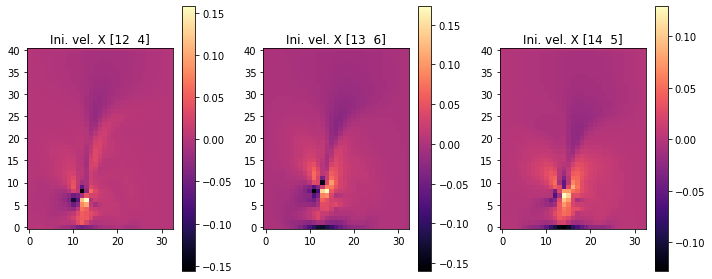

In [8]:
fig, axes = pylab.subplots(1, 3, figsize=(10, 4))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  im = axes[i].imshow(initial_velocity.staggered_tensor().numpy('inflow_loc,y,x,vector')[i,...,0], origin='lower', cmap='magma')
  axes[i].set_title(f"Ini. vel. X {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[i])
pylab.tight_layout()


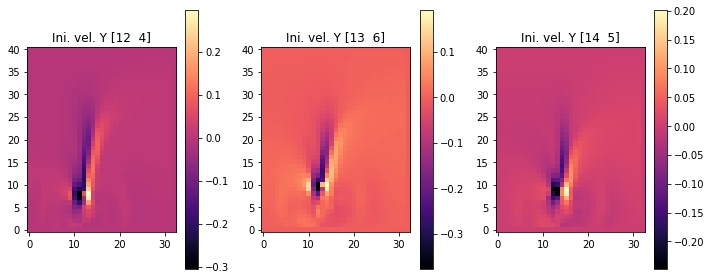

In [9]:
fig, axes = pylab.subplots(1, 3, figsize=(10, 4))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  im = axes[i].imshow(initial_velocity.staggered_tensor().numpy('inflow_loc,y,x,vector')[i,...,1], origin='lower', cmap='magma')
  axes[i].set_title(f"Ini. vel. Y {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[i])
pylab.tight_layout()


## Re-simulation

We can also visualize how the full simulation over the course of 20 steps turns out, given the new initial velocity conditions for each of the inflow locations. This is what happened internally at optimization time for every gradient calculation, and what was measured by our loss function. Hence, it's good to get an intuition for which solutions the optimization has found.

Below, we re-run the forward simulation with the new initial conditions from `initial_velocity`:


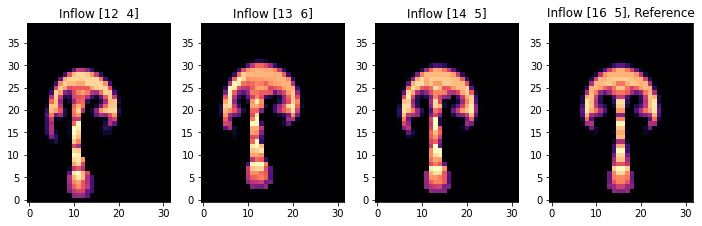

In [10]:
smoke = initial_smoke 
velocity = initial_velocity

for _ in range(20):
    smoke,velocity = step(smoke,velocity)

fig, axes = pylab.subplots(1, 4, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')):
  axes[i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...], origin='lower', cmap='magma')
  axes[i].set_title(f"Inflow {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}" + (", Reference" if i==3 else ""))
pylab.tight_layout()


Naturally, the image on the right is the same (this is the reference), and the other three simulations now exhibit a  shift towards the right. As the differences are a bit subtle, let's visualize the difference between the target configuration and the different final states.

The following images contain the difference between the evolved simulated and target density. Hence, dark regions indicate where the target should be, but isn't. The top row shows the original states with the initial velocity being zero, while the bottom row shows the versions after the optimization has tuned the initial velocities. Hence, in each column you can compare before (top) and after (bottom): 


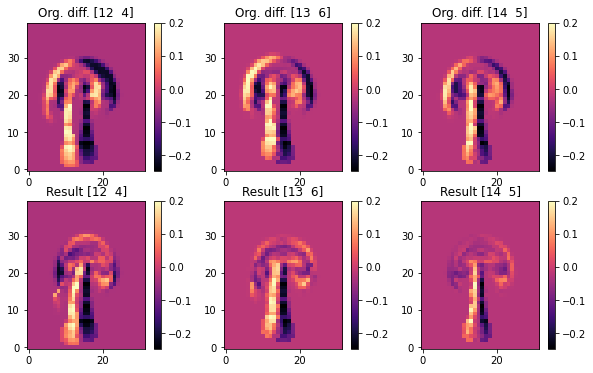

In [14]:
fig, axes = pylab.subplots(2, 3, figsize=(10, 6))
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  axes[0,i].imshow(smoke_final.values.numpy('inflow_loc,y,x')[i,...] - smoke_final.values.numpy('inflow_loc,y,x')[3,...], origin='lower', cmap='magma')
  axes[0,i].set_title(f"Org. diff. {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[0,i])
for i in range(INFLOW.shape.get_size('inflow_loc')-1):
  axes[1,i].imshow(smoke.values.numpy('inflow_loc,y,x')[i,...] - smoke_final.values.numpy('inflow_loc,y,x')[3,...], origin='lower', cmap='magma')
  axes[1,i].set_title(f"Result {INFLOW_LOCATION.numpy('inflow_loc,vector')[i]}")
  pylab.colorbar(im,ax=axes[1,i])

These difference images clearly show that the optimization managed to align the upper region of the plumes very well. Each original image (at the top) shows a clear misalignment in terms of a black halo, while the states after optimization largely overlap the target smoke configuration of the reference, and exhibit differences closer to zero for the front of each smoke cloud.

Note that all three simulations need to "work" with a fixed inflow, hence they cannot simply "produce" marker density out of the blue to match the target. Also each simulation needs to take into account how the non-linear model equations change the state of the system over the course of 20 time steps. So the optimization goal is quite difficult, and it is not possible to exactly satisfy the constraints to match the reference simulation in this scenario. E.g., this is noticeable at the stems of the smoke plumes, which still show a black halo after the optimization. The optimization was not able to shift the inflow position, and hence needs to focus on aligning the upper regions of the plumes.


## Conclusions

This example illustrated how the differentiable physics approach can easily be extended towards significantly more 
complex PDEs. Above, we've optimized for a mini-batch of 20 steps of a full Navier-Stokes solver.

This is a powerful basis to bring NNs into the picture. As you might have noticed, our degrees of freedom were still a regular grid, and we've jointly solved a single inverse problem. There were three cases to solve as a mini-batch, of course, but nonetheless the setup still represents a direct optimization. Thus, in line with the PINN example of {doc}`physicalloss-code` we've not really dealt with a _machine learning_ task here. However, that will be the topic of the next chapters.


## Next steps

Based on the code example above, we can recommend experimenting with the following:

- Modify the setup of the simulation to differ more strongly across the four instances, run longer, or use a finer spatial discretization (i.e. larger grid size). Note that this will make the optimization problem tougher, and hence might not converge directly with this simple setup.

- As a larger change, add a multi-resolution optimization to handle cases with larger differences. I.e., first solve with a coarse discretization, and then uses this solution as an initial guess for a finer discretization. 
